<a href="https://colab.research.google.com/github/pakrentos/eeg_connectivity/blob/master/mlp_eeg_nikita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import numpy as np
import scipy as sp
from scipy.integrate import solve_ivp
from scipy.signal import butter, lfilter
from matplotlib import pyplot as plt
from os.path import join
import time
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score

In [4]:
###Added
import seaborn as sns
import pandas as pd


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
sfq = 250 # Было 250

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [26]:
class FloatingWindow():
    
    def __init__(self, arr_src, arr_trgt, sfreq=250, twin=1., pwin=1., step=1.):
        assert arr_src.shape == arr_trgt.shape, 'Source and target arrays should be in the same shape'
        assert len(arr_src.shape) == 1, 'Arrays should be 1D'
        self.data = np.vstack((arr_src, arr_trgt)).T
        self.twin = int(twin*sfreq)
        self.pwin = int(pwin*sfreq)
        self.step = int(step*sfreq)
        self.end = (self.data.shape[0] - (self.twin + self.pwin))//self.step
    
    def __iter__(self):
        self._iter = 0
        return self
    
    def __next__(self):
        if self._iter == self.end:
            raise StopIteration
        win = self.data[self.step*self._iter : self.step*self._iter + self.twin + self.pwin]
        train = win[:self.twin].T
        predict = win[self.twin:].T
        src = train[0][np.newaxis, :].T         # shape (n, 1)
        trgt = train[1][np.newaxis, :].T        # shape (n, 1)
        src_p = predict[0][np.newaxis, :].T     # shape (n, 1)
        trgt_p = predict[1]                     # shape (n,)
        self._iter += 1
        return src, trgt, src_p, trgt_p

class PashorgWindow():
    
    def __init__(self, arr_src, arr_trgt, sfreq=250, twin=1., step=1.):
        assert arr_src.shape == arr_trgt.shape, 'Source and target arrays should be in the same shape'
        assert len(arr_src.shape) == 1, 'Arrays should be 1D'
        self.data = np.vstack((arr_src, arr_trgt)).T
        self.twin = int(twin*sfreq)
        self.step = int(step*sfreq)
        self.end = (self.data.shape[0] - self.twin)//self.step
    
    def __iter__(self):
        self._iter = 0
        return self
    
    def __next__(self):
        if self._iter == self.end:
            raise StopIteration
        win = self.data[self.step*self._iter : self.step*self._iter + self.twin]
        win = np.random.permutation(win)
        train = win[:win.shape[0]//2].T
        predict = win[win.shape[0]//2:].T
        src = train[0][np.newaxis, :].T
        trgt = train[1][np.newaxis, :].T
        src_p = predict[0][np.newaxis, :].T
        trgt_p = predict[1][np.newaxis, :]
        self._iter += 1
        return src, trgt, src_p, trgt_p


In [10]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [11]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

def coeff_determination_simp(y_true, y_pred):
    res = np.sum(np.square(y_true - y_pred))
    y_true_mean = np.tile(np.mean(y_true, axis=-1), y_true.shape[-1]).reshape((y_true.shape[-1], y_true.shape[-2])).T
    tot = np.sum(np.square(y_true - y_true_mean))
    return 1 - res/(tot + K.epsilon())

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Dense(1, activation='linear'))
model.add(layers.Dense(10, activation='softmax'))
model.add(layers.Dense(10, activation='softmax'))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='mse',
              metrics=[coeff_determination])


In [12]:
### ADDED
def get_model():
  model2 = tf.keras.Sequential()
  model2.add(layers.Dense(1, activation='linear'))
  model2.add(layers.Dense(20, activation='tanh'))
  model2.add(layers.Dense(20, activation='tanh'))
  model2.add(layers.Dense(1, activation='linear'))

  model2.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss='mse',
                metrics=[coeff_determination])
  return model2


In [13]:
mapping = [
    ('O2','A2'),
    ('O1','A1'),
    ('P4','A2'),
    ('P3','A1'),
    ('C4','A2'),
    ('C3','A1'),
    ('F4','A2'),
    ('F3','A1'),
    ('Fp2','A2'),
    ('Fp1','A1'),
    ('T6','A2'),
    ('T5','A1'),
    ('T4','A2'),
    ('T3','A1'),
    ('F8','A2'),
    ('F7','A1'),
    ('Oz','A2'),
    ('Pz','A1'),
    ('Cz','A2'),
    ('Fz','A1'),
    ('Fpz','A2'),
    ('FT7','A1'),
    ('FC3','A1'),
    ('Fcz','A1'),
    ('FC4','A2'),
    ('FT8','A2'),
    ('TP7','A1'),
    ('CP3','A1'),
    ('Cpz','A1'),
    ('CP4','A2'),
    ('TP8','A2'), 
]
r_mapping = {mapping[i][0]:i for i in range(len(mapping))}
    

In [14]:
def extract(data_stream):
    raw_data = data_stream.readlines()
    data = []
    for line in raw_data:
        temp = np.array([float(x) for x in line.split()])
        data.append(temp)
    return np.array(data)

def format_fname(_group, _hand, _subj, _tr_num):
    directory = 'drive/My Drive/Subjects'
    fname_pattern = f'{_group}_subject_{_subj}_{_hand}_tr_{_tr_num}.dat'
    return join(directory, fname_pattern)

hands = ('lefthand', 'righthand')
groups = ('OLD', 'YOUNG')
subjects = np.arange(1, 11)
trials = np.arange(1, 16)
total = len(hands)*len(groups)*len(subjects)*len(trials)

In [15]:
epochs = []

for trial in trials:
    fin = open(format_fname('YOUNG', hands[1], subjects[0], trial))
    epochs.append(extract(fin))
    fin.close()

epochs = np.array(epochs)

In [16]:
t = np.linspace(0, 12, 3001)
tp7 = epochs[::, r_mapping['TP7'], sfq*2::]
cz = epochs[::, r_mapping['Cz'], sfq*2::]
lowcut = 8.0
highcut = 12.0
cz_filtered = butter_bandpass_filter(cz, lowcut, highcut, sfq, order=6)
tp7_filtered = butter_bandpass_filter(tp7, lowcut, highcut, sfq, order=6)
tp7_filtered = np.array([(tp7_filtered[i] - np.min(tp7_filtered[i]))/(np.max(tp7_filtered[i]) - np.min(tp7_filtered[i])) for i in range(len(tp7_filtered))])
cz_filtered = np.array([(cz_filtered[i] - np.min(cz_filtered[i]))/(np.max(cz_filtered[i]) - np.min(cz_filtered[i])) for i in range(len(cz_filtered))])

In [41]:
coefs = []
best = None
for tr in range(15):
    temp = []
    it = 0
    for src, trgt, src_p, trgt_p in FloatingWindow(cz_filtered[tr], tp7_filtered[tr], step=0.2, twin=0.5, pwin=0.5):
        model = get_model()
        model.fit(src, trgt, epochs=10, batch_size=32, verbose=False)
        res = model.predict(src_p, verbose=False).T[0]
        c = r2_score(trgt_p, res)
        it += 1
        print(f'Current trial: {tr} ### Iteration: {it} ### Fit: {c}')
        if best is None or (isinstance(best, tuple) and best[-1] < c):
          best = (it, trgt_p, res, c)
    coefs.append(temp)
    print('@@@ New trial @@@')

Current trial: 0 ### Iteration: 1 ### Fit: 0.37237622304702767
Current trial: 0 ### Iteration: 2 ### Fit: 0.3704661945658929
Current trial: 0 ### Iteration: 3 ### Fit: 0.7334712367553207
Current trial: 0 ### Iteration: 4 ### Fit: 0.19838064519828502
Current trial: 0 ### Iteration: 5 ### Fit: -0.01104692649156358
Current trial: 0 ### Iteration: 6 ### Fit: -0.33445291335584293
Current trial: 0 ### Iteration: 7 ### Fit: 0.023134054009784966
Current trial: 0 ### Iteration: 8 ### Fit: 0.0196707568399197
Current trial: 0 ### Iteration: 9 ### Fit: 0.00991570104549322
Current trial: 0 ### Iteration: 10 ### Fit: -0.256821791414233
Current trial: 0 ### Iteration: 11 ### Fit: -0.654841596048227
Current trial: 0 ### Iteration: 12 ### Fit: -0.40697715924915157
Current trial: 0 ### Iteration: 13 ### Fit: -0.17729939541873163
Current trial: 0 ### Iteration: 14 ### Fit: 0.1550906455298745
Current trial: 0 ### Iteration: 15 ### Fit: 0.4465511056072299
Current trial: 0 ### Iteration: 16 ### Fit: 0.35664

In [ ]:
### Added
#Создание модели
def baseline_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(1, activation='linear'))
    model.add(layers.Dense(20, activation='tanh'))
    model.add(layers.Dense(20, activation='tanh'))
    model.add(layers.Dense(1, activation='linear'))
    #Компиляция модели
    model.compile(loss=coeff_determination, optimizer=tf.optimizers.Adam(0.001))
    return model

0.7651388293029807


Text(0.5, 0.98, 'ya ne ibu che ya delay')

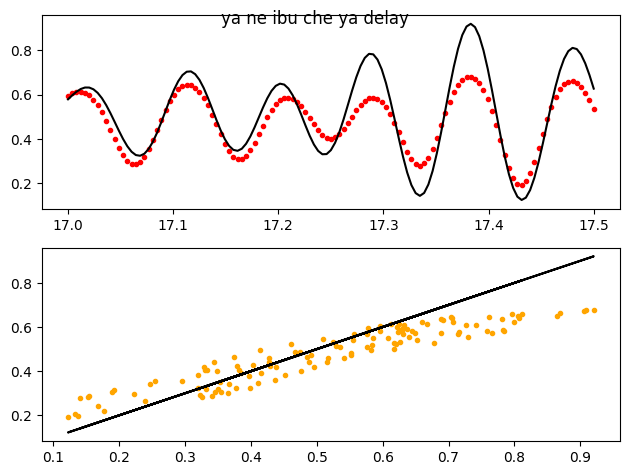

In [66]:
print(best[-1])
plt.rcdefaults()
plt.subplot(2, 1, 1)
plt.plot(np.linspace(best[0]*0.5 + 0.5, best[0]*0.5 + 1, len(best[1]) ), best[2], '.r')
plt.plot(np.linspace(best[0]*0.5 + 0.5, best[0]*0.5 + 1, len(best[1]) ), best[1], color='black')

plt.subplot(2,1,2)

plt.plot(best[1], best[2], color='orange', marker = '.', linestyle='')
plt.plot(best[1], best[1], color='black')
plt.tight_layout()
plt.suptitle('ya ne ibu che ya delay')

In [ ]:
### Added
coefs = {}
histories = []
for i in range(14):
    model = baseline_model()
    temp = []
    src = cz_filtered[0:2, int(sfq*2+sfq*i*0.75):2+int(sfq*(i+1)*0.75)].T
    trgt = tp7_filtered[0:2, int(2+sfq*i*0.75):int(sfq*(i+1)*0.75)].T
    src_next = cz_filtered[0:2, int(sfq*(i+1)):int(sfq*(i+2))].T
    trgt_next = tp7_filtered[0:2, int(sfq*(i+1)):int(sfq*(i+2))].T
    histories = model.fit(src, trgt, epochs=100, batch_size=32, verbose=False)
    res = model.predict(src_next, verbose=False)
    c = coeff_determination_simp(trgt_next.T, res.T)
    temp.append(c)
    print(f'Current trial: {0} ### Second: {i}-{i+1} ### Fit: {c}')

ValueError: ignored

In [1]:
###ADDED
### Рисует график обучения (loss function) и график метрики (coeff_determination). Своровано и адаптировано отсюда: https://www.tensorflow.org/tutorials/keras/regression?hl=ru
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Coefficient of determination')
    plt.plot(hist['epoch'], hist['coeff_determination'],
           label='Coefficient of determination')
    plt.plot(hist['epoch'], hist['loss'],
           label = 'Loss function')
    plt.ylim([0,5])
    plt.legend()
    plt.show()


plot_history(history)

NameError: ignored

In [44]:
coefs = list(coefs.values())

AttributeError: ignored

In [45]:
coefs = np.array(coefs)

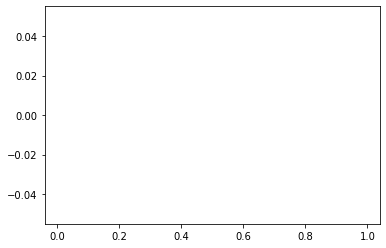

In [46]:
plt.hist(coefs.T);

In [ ]:
coefs.shape # 15 триалов, в каждом по 9 окон. массив хранит данные о фите для каждого окна

(15, 22)

In [ ]:
len(coefs[0].shape)

1

In [ ]:
sas = [list(x) for x in coefs]

In [ ]:
import json

In [ ]:
sos = {'data': sas}

In [ ]:
f = open('drive/My Drive/biba.josn', 'w')
json.dump(sos, f)
f.close()